In [1]:
import torch
import torchvision.transforms as T
from torch import nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
from base64 import b64encode
from tqdm import tqdm
import numpy as np
import os
import cv2
from IPython.display import Video


In [2]:
def show_grid(maxn=20, w=3, h=3):
    """Assuming images have been saved in steps/ and there are
    at least maxn of them with the naming convention 0001.jpeg.
    This function loads w x h images and shows them in a grid.
    Useful for a quick preview to see if anything interesting is
    happening"""
    fig, axs = plt.subplots(h, w)
    plt.tight_layout()
    for x in range(h):
        for y in range(w):
            i = int(maxn * (x * w + y) / (w * h))
            axs[x][y].imshow(Image.open(f"steps/{i:05}.jpeg"))


def render(ca, n=100, w=256, h=256, save_every=1, exp_frac=0, display_grid=True):
    """Render n steps of a ca starting from a random grid.
    Saves an image every save_every steps into the steps/ folder.
    Smooths the aniation with exponential averaging set by exp_frac
    """
    !rm -r steps
    !mkdir steps
    grid = torch.rand(1, 1, w, h)  # bs, channels, w, h
    im_array = np.array(grid[0][0].clip(0, 1))
    for i in tqdm(range(n)):
        grid = ca(grid)
        im_array = exp_frac * im_array + (1 - exp_frac) * np.array(
            grid[0][0].clip(0, 1)
        )
        im = Image.fromarray(np.uint8(cm.gist_earth(im_array) * 255)).convert("RGB")
        if i % save_every == 0:
            im.save(f"steps/{i//save_every:05}.jpeg")
    if display_grid:
        show_grid(maxn=30, w=3, h=2)


def progress_video(name="nca.mp4"):
    """
    Create a video from the images saved in the steps/ folder."""
    path = "steps/"
    out_video_name = "temp_nca.mp4"
    out_video_full_path = out_video_name

    pre_imgs = os.listdir(path)
    pre_imgs.sort()
    # print(pre_imgs)
    img = []
    # exit()
    for i in pre_imgs:
        i = path + i
        # print(i)
        img.append(i)

    # print(img)

    cv2_fourcc = cv2.VideoWriter_fourcc(*"mp4v")

    frame = cv2.imread(img[0])
    size = list(frame.shape)
    del size[2]
    size.reverse()
    # print(size)

    video = cv2.VideoWriter(
        out_video_full_path, cv2_fourcc, 24, size
    )  # output video name, fourcc, fps, size

    for i in range(len(img)):
        video.write(cv2.imread(img[i]))

    video.release()
    !ffmpeg -y -i temp_nca.mp4 $name -loglevel quiet
    !rm -f temp_nca.mp4


In [3]:
# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import random

seed = 2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

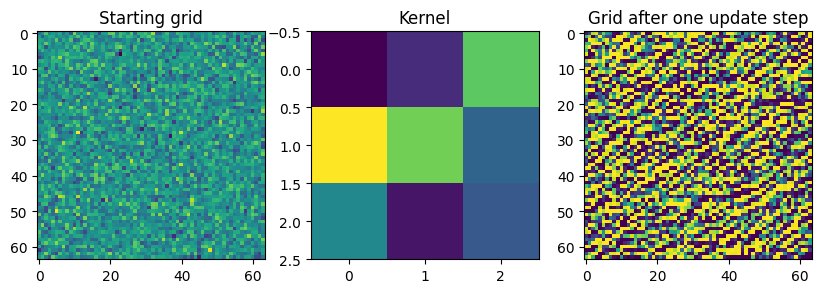

In [5]:
# Create our grid (32x32 for this demo)
grid = torch.randn(1, 1, 64, 64)  # batch_size, channels, w, h

# Create a random kernel
kernel = torch.randn(1, 1, 3, 3)  # batch_size, channels, kernel_size, kernel_size

# Define an activation function
act = torch.tanh

# Compute the output after one step:
output = act(
    F.conv2d(grid, kernel, padding="same")
)  # Think: What happens to the sizes if we remove padding?

# Visualize the various arrays:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(grid[0][0])
axs[0].set_title("Starting grid")
axs[1].imshow(kernel[0][0])
axs[1].set_title("Kernel")
axs[2].imshow(output[0][0])
axs[2].set_title("Grid after one update step")
plt.show()

In [6]:
class ConvCA(nn.Module):
    """Applies a convolutional kernel over an image and passes the result through
    an activation function."""

    def __init__(self, kernel_size=3, kernel_scale=0.5, act=torch.tanh):
        # @param kenel_scale : update scale rate of the kernel

        super().__init__()
        self.kernel = torch.randn(1, 1, kernel_size, kernel_size) * kernel_scale
        self.act = act

    def forward(self, x):
        return self.act(F.conv2d(x, self.kernel, padding=1))

/tmp/ipykernel_68023/3917156613.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = np.array(grid[0][0].clip(0, 1))
  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_68023/3917156613.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = exp_frac * im_array + (1 - exp_frac) * np.array(
100%|██████████| 100/100 [00:00<00:00, 958.26it/s]


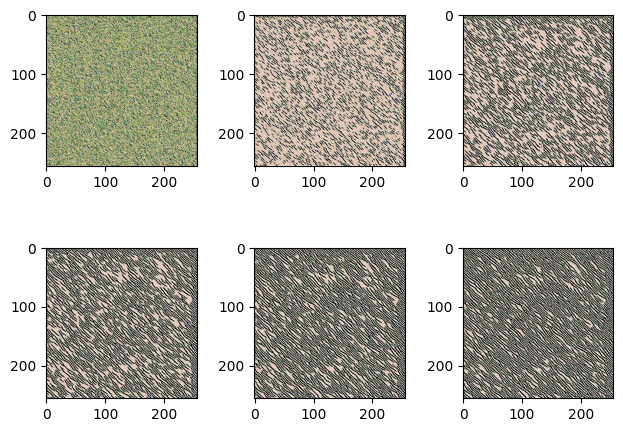

In [7]:
ca = ConvCA(kernel_scale=0.5)
render(ca)

In [8]:
# Convert step images to video
progress_video(name="random_ca.mp4")
Video("random_ca.mp4", width=500, height=500)

In [9]:
render(ca, n=1000, save_every=1, exp_frac=0.8, display_grid=False)

# Convert step images to video
name = "random_ca_smooth.mp4"
progress_video(name)
Video(name, width=500, height=500)

/tmp/ipykernel_68023/3917156613.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = np.array(grid[0][0].clip(0, 1))
  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_68023/3917156613.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = exp_frac * im_array + (1 - exp_frac) * np.array(
100%|██████████| 1000/1000 [00:00<00:00, 1198.24it/s]


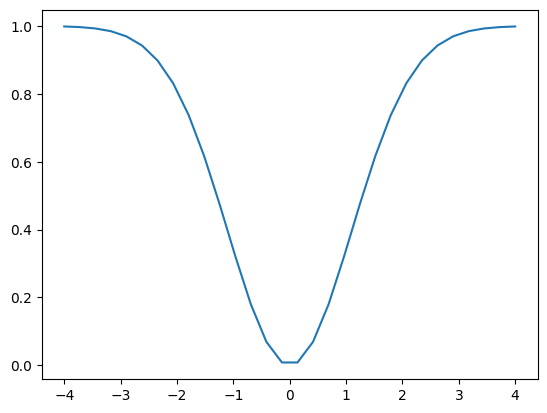

In [10]:
def inverse_gaussian(x):
    return -1.0 / torch.pow(2.0, (0.6 * torch.pow(x, 2.0))) + 1.0


# Plot:
x = torch.linspace(-4, 4, 30)
plt.plot(x, inverse_gaussian(x))

In [11]:
worm_ca = ConvCA(act=inverse_gaussian)
worm_ca.kernel = torch.tensor(
    [[[[0.68, -0.9, 0.68], [-0.9, -0.6, -0.9], [0.68, -0.9, 0.68]]]]
)
render(worm_ca, n=2000, save_every=10, exp_frac=0.8, display_grid=False)

name = "worms_nca.mp4"
progress_video(name=name)
Video(name, width=500, height=500)

/tmp/ipykernel_68023/3917156613.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = np.array(grid[0][0].clip(0, 1))
  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_68023/3917156613.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = exp_frac * im_array + (1 - exp_frac) * np.array(
100%|██████████| 2000/2000 [00:02<00:00, 694.22it/s]


In [12]:
def swich(x):
    return x * torch.sigmoid(x)


def mish(x):
    return x * torch.tanh(nn.functional.softplus(x))


def elish(x):
    return torch.where(
        x > 0, x * torch.sigmoid(x), (torch.exp(x) - 1) * torch.sigmoid(x)
    )


worm_ca = ConvCA(act=elish)
render(worm_ca, n=2000, save_every=10, exp_frac=0.8, display_grid=False)

name = "relu_nca.mp4"
progress_video(name=name)
Video(name, width=500, height=500)

/tmp/ipykernel_68023/3917156613.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = np.array(grid[0][0].clip(0, 1))
  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_68023/3917156613.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = exp_frac * im_array + (1 - exp_frac) * np.array(
100%|██████████| 2000/2000 [00:01<00:00, 1275.06it/s]


In [13]:
worm_ca = ConvCA(act=torch.tanh)
render(worm_ca, n=2000, save_every=10, exp_frac=0.8, display_grid=False)

name = "tanh_nca.mp4"
progress_video(name=name)
Video(name, width=500, height=500)

/tmp/ipykernel_68023/3917156613.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = np.array(grid[0][0].clip(0, 1))
  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_68023/3917156613.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  im_array = exp_frac * im_array + (1 - exp_frac) * np.array(
100%|██████████| 2000/2000 [00:02<00:00, 951.67it/s] 


# NCA

In [14]:
import torch
import torchvision.transforms as T
from torch import nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
from base64 import b64encode
from tqdm import tqdm
import numpy as np
import os
import cv2
from IPython.display import Video


def create_gif(image_tensors, filename):
    image_tensors[0].save(
        filename, save_all=True, append_images=image_tensors[1:], duration=70, loop=100
    )

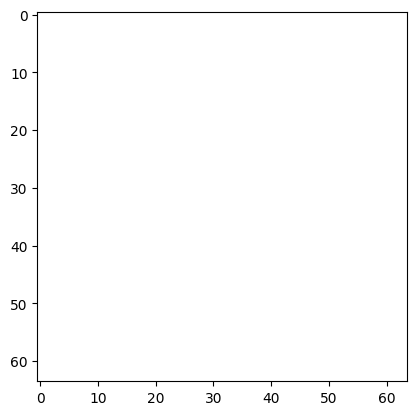

In [15]:
from model import NeuralCellularAutomata

nca = NeuralCellularAutomata()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = torch.zeros(16, 64, 64).to(device)
seed[3:, 64 // 2, 64 // 2] = 1
seed[3:, 64 // 2, 64 // 2] = 1

image_tensors = []

seed = seed.unsqueeze(0)
for i in range(1000):
    seed = nca.update(seed)
    img = (seed.squeeze(0)[:4, :, :].transpose(0, 2).clamp(0, 1).detach().cpu().numpy() * 255)
    image_tensors.append(Image.fromarray((img).astype(np.uint8)))

create_gif(image_tensors, "random.gif")

plt.imshow(image_tensors[-1])

# Training

In [16]:
import torch
import torchvision.transforms as T
from torch import nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
from base64 import b64encode
from tqdm import tqdm
import numpy as np
import os
import cv2
from IPython.display import Video

def create_gif(image_tensors, filename):
    image_tensors[0].save(
        filename, save_all=True, append_images=image_tensors[1:], duration=100, loop=0
    )

/home/user/neural-cellular-automata/src/model.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


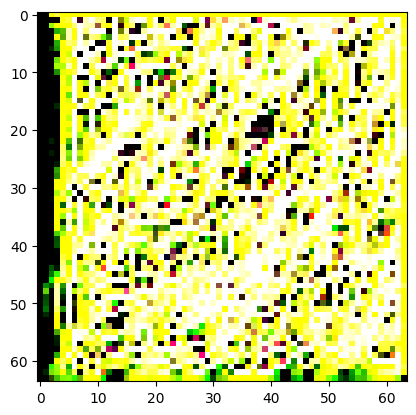

In [17]:
from model import NeuralCellularAutomata

nca = NeuralCellularAutomata()
nca.load(path="../model.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = torch.zeros(16, 64, 64).to(device)
seed[3:, 64 // 2, 64 // 2] = 1
seed[3:, 64 // 2, 64 // 2] = 1

image_tensors = []

seed = seed.unsqueeze(0)
for i in range(2000):
    seed = nca.update(seed)
    img = (seed.squeeze(0)[:4, :, :].transpose(0, 2).clamp(0, 1).detach().cpu().numpy() * 255)
    image_tensors.append(Image.fromarray((img).astype(np.uint8)))

create_gif(image_tensors, "result.gif")

plt.imshow(image_tensors[-1])